In [11]:
import jax
from jax import numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import ces
import balance

In [12]:
vvp8 = [24.8, 26.062, 27.312, 29.304, 31.407, 33.410, 36.135, 39.219, 41.277, 38.049, 39.762, 41.458, 62.486, 63.602, 64.072] #ВВП 0-14 года в ценах 8ого
curs_abs = [28.13, 29.18, 31.36, 30.67, 28.81, 28.31, 27.14, 25.55, 24.87, 31.77, 30.38, 29.39, 31.08, 31.90, 38.60] #курс доллара
zp_rel = [1.209, 1.199, 1.162, 1.109, 1.106, 1.126, 1.133, 1.172, 1.115, 0.965, 1.052, 1.028, 1.084, 1.048, 1.012] #реальная зп в процентах от предыдущей
zp_abs = [np.exp(np.sum(np.log(zp_rel[:year+1]))) for year in range(15)]
tables = balance.read_NIOT('NIOTS/RUS_NIOT_nov16.xlsx')

In [13]:
class balance_module():
    def __init__(self, n, m, rho_min = 0.1, rho_max = 10, seed = 0):
        self.n = n
        self.m = m
        self.key = jax.random.PRNGKey(seed)
        
        self.rho_min = rho_min
        self.rho_max = rho_max
        self.rho = jax.random.uniform(self.key, (n,), minval= rho_min, maxval = rho_max)
        self.Z = jnp.zeros((n+m, n))
        self.Z = self.Z.at[:n,:].set(jnp.ones((n,n))/(n+1))
        self.Z = self.Z.at[n:,:].set(jnp.ones((m,n)))
        
    def forward(self, Z, rho, s, h, Z0): 
        W = ces.W(Z, rho)
        p = ces.balance_prices(W, rho, s, h)
        J = ces.J(p, W, rho)
        Z_pred = balance.J_to_Z(J, Z0) 
        return Z_pred
    
    def loss(self, params, x, y): #по-хорошему loss нужно сделать снаружи, а тут сделать только train 
        Z, rho = params
        n, m = Z.shape
        n, m = m, n - m
        s, h, Z0 = x
        Z_target = y
        Z_pred = self.forward(Z, rho, s, h, Z0)
        L_pred = Z_pred[n:,:]
        L_target = Z_target[n:,:]
        #loss = jnp.trace(jnp.transpose(Z_pred - Z_target) @ (Z_pred - Z_target))
        loss = jnp.sum(jnp.abs(L_pred - L_target))
        # loss = jnp.sum(jnp.abs(Z_pred - Z_target))
        return loss

In [14]:
#при таком rho когда-то что-то падало 
rho_bad = jnp.array([6.2238083, 0.1, 5.8205304, 7.1875806, 9.16447, 2.919602, 3.565998,
           3.560337, 1.2712448, 3.534269, 8.417102, 1.698983, 1.9197848, 8.21868,
           3.623436, 7.301276, 4.6853094, 3.9526048, 7.5603304, 5.5858884, 6.32079,
           4.484683, 8.182239, 4.472176, 3.2741904, 1.5513074, 4.2444315, 8.1515465,
           6.1587143, 0.6000987, 3.2279983, 5.2498374, 2.1840897])

In [15]:
curs = [x/curs_abs[8] for x in curs_abs] 
vvp = [vvp8[8]/x for x in vvp8] #или наоборот нужно
zp = [x/zp_abs[8] for x in zp_abs]

In [16]:
n, m = 33, 3
years = range(15)
Zs = [tables[year][:,:n] for year in years]
Z0s = [jnp.sum(tables[year][:n,n:], axis = 1) for year in years]
xs = [(jnp.array([curs[year], zp[year], vvp[year]]), jnp.zeros((n,)), Z0s[year]) for year in years]
ys = [(Zs[year]) for year in years]
DATA = [(xs[year], ys[year]) for year in years] #вот на этом будем обучать

In [17]:
model = balance_module(n, m)
model.Z = tables[8][:,:n]

In [18]:
gamma_rho = 1
gamma_Z = 1
rho_min = 0.25
rho_max = 25.0

for _ in range(10):
    print('******************')
    eps_rho = 0
    eps_Z = 0
    cum_rho = 0
    cum_Z = 0
    for i in range(100):
        grad_rho = jnp.zeros((n,))
        grad_Z = jnp.zeros((n+m,n))
        last_loss = 0
        x, y = DATA[np.random.randint(0,15)]
        #for x, y in DATA:
        last_loss += model.loss((model.Z, model.rho), x, y)
        grad = jax.jacrev(model.loss)((model.Z, model.rho), x, y)
        grad_rho += grad[1]
        grad_Z += grad[0]
        #mask_zero = (model.rho == rho_max) * (grad_rho < 0) + (model.rho == rho_min) * (grad_rho < 0)
        #grad_rho = (1 - mask_zero) * grad_rho
        eps_rho = jnp.dot(grad_rho, grad_rho)
        eps_Z = jnp.trace(jnp.transpose(grad_Z) @ grad_Z)
        if(jnp.isnan(eps_rho)):
            print('поймал ошибку по rho')
            break
        if(jnp.isnan(eps_Z)):
            print('поймал ошибку по Z')
            break
        print(eps_rho, eps_Z, last_loss)
        print('_______')
        cum_rho += eps_rho
        cum_Z += eps_Z
        rho = model.rho - gamma_rho/jnp.sqrt(cum_rho) * grad_rho
        rho = jnp.minimum(jnp.maximum(rho, rho_min),rho_max)
        model.rho = model.rho.at[:].set(rho)
        Z = model.Z - gamma_Z/jnp.sqrt(cum_Z) * grad_Z
        Z = jnp.maximum(Z, 0.1)
        model.Z = model.Z.at[:,:].set(Z)

******************
0.00046837132 768.6113 0.18045044
_______
3708356.8 1020.4574 176467.06
_______
22083.318 365.31305 78189.016
_______
68518.56 36.29196 74659.2
_______
52090.023 20.715998 67660.89
_______
6707.9814 377.42163 64650.453
_______
177669.66 147.4349 58006.82
_______
2286824.2 1019.8561 174496.22
_______
2688227.0 818.75745 190685.1
_______
185477.05 148.06259 57862.54
_______
164245.56 148.04749 57801.117
_______
928742.94 960.65955 135751.23
_______
42110.707 86.38939 66385.875
_______
53512.93 516.9818 109663.77
_______
80356.69 36.30695 74561.85
_______
1758794.1 1021.07153 172509.1
_______
220524.16 149.24316 57830.453
_______
105933.836 216.94193 58684.58
_______
55649.527 516.96106 109611.195
_______
26115.793 46.503777 77390.16
_______
83784.484 36.31009 74533.65
_______
40525.016 86.37722 66305.266
_______
150830.34 821.3689 116015.266
_______
2323090.0 818.14435 188608.17
_______
43749.453 86.36775 66237.07
_______
43929.152 86.366974 66225.016
_______
47854.12 

0.09329012


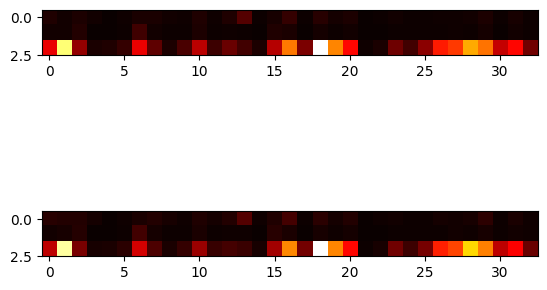

In [19]:
year = 14
s, h, Z0 = DATA[year][0]
Z_pred = model.forward(model.Z, model.rho, s, h, Z0)
Z_target = DATA[year][1]
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
ax1.imshow(Z_pred[n:,:], cmap='hot', interpolation='nearest')
ax2.imshow(Z_target[n:,:], cmap='hot', interpolation='nearest') 
print(jnp.sum(jnp.abs(Z_pred[n:,:]-Z_target[n:,:]))/(jnp.sum(jnp.abs(Z_target[n:,:]))))

0.09329012


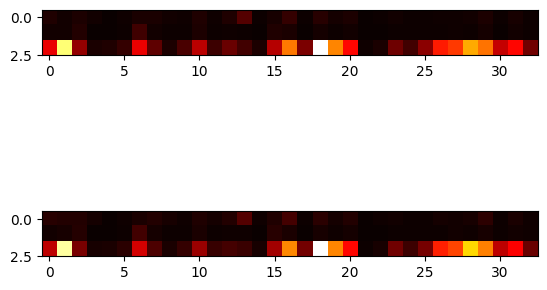

In [20]:
year = 14
s, h, Z0 = DATA[year][0]
Z_pred = model.forward(model.Z, model.rho, s, h, Z0)
Z_target = DATA[year][1]
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
ax1.imshow(Z_pred[n:,:], cmap='hot', interpolation='nearest')
ax2.imshow(Z_target[n:,:], cmap='hot', interpolation='nearest') 
print(jnp.sum(jnp.abs(Z_pred[n:,:]-Z_target[n:,:]))/(jnp.sum(jnp.abs(Z_target[n:,:]))))

При фиксированных $\rho$ оно выучивает базовый год, но долго, муторно и с рестартами. Про рестарты особенно интересно - функция ну явно не сильно выпукла, но заметно помогает. При обучаемых $rho$ и $Z$ ситуация заметно хуже, особенно учитывая, что я не сделал проекцию на корректные $I/O-$матрицы и равновесных цен на каком-то шаге может и не существовать. Работает плохо.  